In [1]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import pickle
import argparse
import networkx as nx

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt

from torch.autograd import Variable

from models.model_wrapper import MLP
from data import datasets
from data.graph_wrapper import GeneManiaGraph, RegNetGraph
from data.utils import record_result

In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)
label_df = dataset.df.where(dataset.df > 0).notnull().astype("int")

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 1668 finished pieces out of 1668 total pieces.
Converting one-hot labels to integers


In [3]:
graphs = {"regnet": RegNetGraph(), "genemania": GeneManiaGraph()}


Torrent name: kegg.hdf5, Size: 209.06MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 1595 finished pieces out of 1595 total pieces.
Torrent name: gene-mania-graph.hdf5, Size: 1066.39MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 2034 finished pieces out of 2034 total pieces.


In [4]:
# Setup the results dictionary
filename = "experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(filename, "rb"))
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [5]:
train_size = 50
test_size = 1000
trials = 3
cuda = True
models = {"BasicMLP": MLP(column_names=dataset.df.columns, dropout=False, cuda=cuda)}


In [6]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), models.keys(), range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 192244
done: 3477


In [7]:
for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = models[model_name]

    experiment = {
        "gene": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
    }

    dataset.labels = label_df[gene]
    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError:
        results = record_result(results, experiment, filename)
        continue
    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        neighbors = [n for n in neighbors if n in X_train.columns.values]
        X_train = X_train.loc[:, neighbors].copy()
        X_test = X_test.loc[:, neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1

    try:
        model.fit(X_train, y_train)
        x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False)\
            .float()
        if cuda:
            x_test = x_test.cuda()
        y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        model.best_model = None # cleanup
        experiment["auc"] = auc
    except Exception as e:
        print(e)
    results = record_result(results, experiment, filename)


3480
3490
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
3500
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
3510
3520
Only one class present in y_true. ROC AUC score is 

KeyboardInterrupt: 

In [8]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


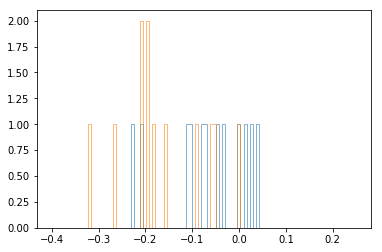

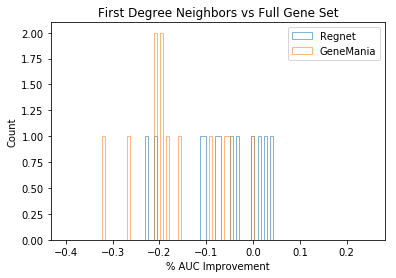

In [9]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()